<a href="https://colab.research.google.com/github/Joizra/Deep-Learning/blob/main/DL_K_Stock_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from google.colab import drive
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 12.6 MB/s eta 0:00:00


# Load the dataset

In [ ]:
# Specify the path to the 7-Zip archive file
archive_path= '/content/drive/My Drive/Colab Notebooks/Deep Learning/TSLA2023.csv'
data = pd.read_csv(archive_path)


In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
1,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
3,2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500
4,2010-07-08,1.076000,1.168000,1.038000,1.164000,1.164000,115671000


In [ ]:
data = data.iloc[:,:2]


# Data Analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3356 entries, 0 to 3355
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3356 non-null   object 
 1   Open    3356 non-null   float64
dtypes: float64(1), object(1)
memory usage: 52.6+ KB


In [ ]:
data.head()

,Date,Open
0,2010-07-01,1.666667
1,2010-07-02,1.533333
2,2010-07-06,1.333333
3,2010-07-07,1.093333
4,2010-07-08,1.076000


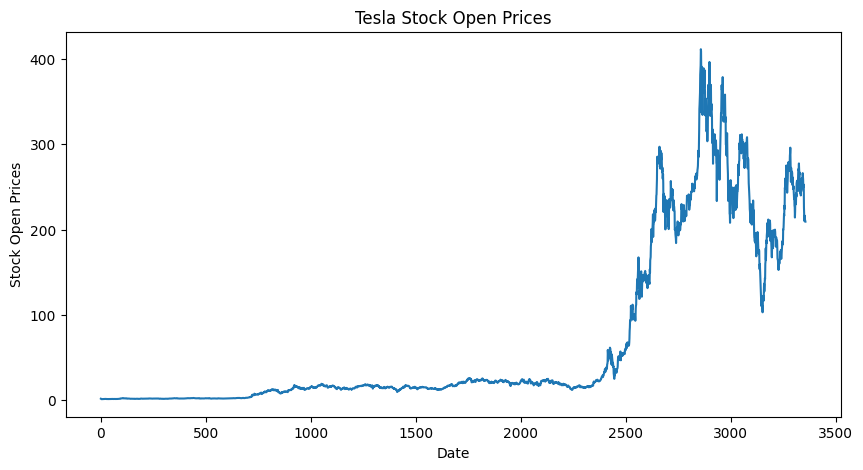

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and it has a column 'Date' with date strings
# and a column 'Open' with the opening stock prices.

data['Date'] = pd.to_datetime(data['Date'])

    # Set the 'Date' column as the index of the DataFrame
#data.set_index('Date', inplace=True)

# Ensure that 'Open' values are positive to avoid issues with logarithm
data['Open'] = data['Open'].clip(lower=0.01)

# Now, the 'Open' column is a time series with the datetime index
open_time_series = data['Open']



# Plot the stationary time series data
plt.figure(figsize=(10, 5))
open_time_series.plot(title='Tesla Stock Open Prices')
plt.xlabel('Date')
plt.ylabel('Stock Open Prices')
plt.show()


# Dataset

In [ ]:
data.head()

,Date,Open
0,2010-07-01,1.666667
1,2010-07-02,1.533333
2,2010-07-06,1.333333
3,2010-07-07,1.093333
4,2010-07-08,1.076000


In [ ]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 3356
Train data length : 2349
Validation data lenth : 1007


In [ ]:
train_data = data[:length_train].iloc[:,:2]
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Date,Open
0,2010-07-01,1.666667
1,2010-07-02,1.533333
2,2010-07-06,1.333333
3,2010-07-07,1.093333
4,2010-07-08,1.076000
...,...,...
2344,2019-10-23,16.966667
2345,2019-10-24,19.891333
2346,2019-10-25,19.848000
2347,2019-10-28,21.836000


In [ ]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

,Date,Open
2349,2019-10-30,20.866667
2350,2019-10-31,20.873333
2351,2019-11-01,21.087999
2352,2019-11-04,20.986668
2353,2019-11-05,21.308001
...,...,...
3351,2023-10-24,216.500000
3352,2023-10-25,215.880005
3353,2023-10-26,211.320007
3354,2023-10-27,210.600006


In [ ]:
dataset_train = train_data.Open.values
dataset_train.shape

(2349,)

In [ ]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(2349, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(2349, 1)

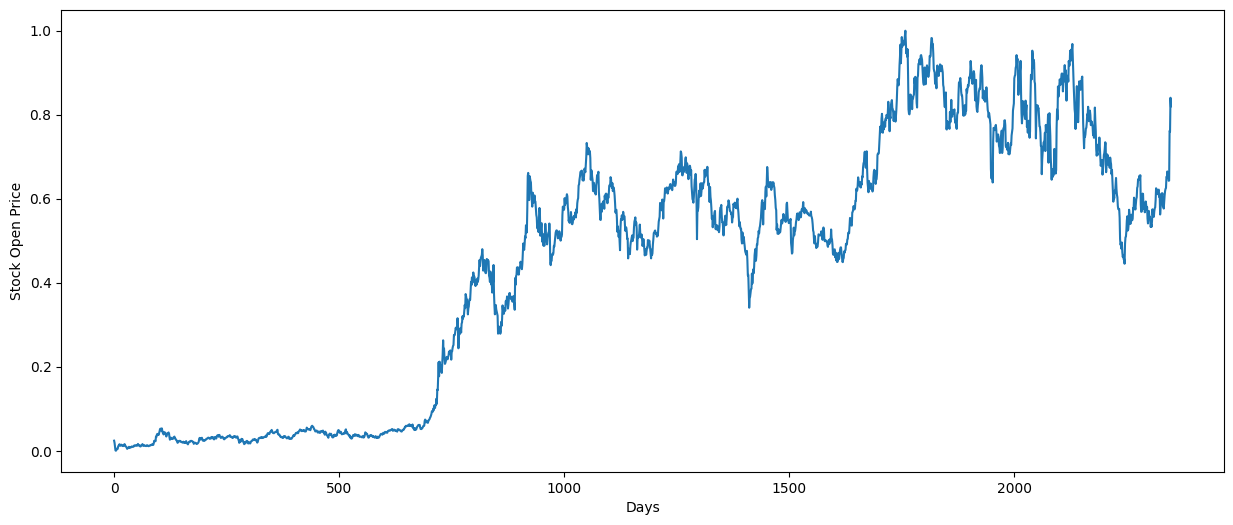

In [ ]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days")
plt.ylabel("Stock Open Price")
plt.show()

## Train

In [ ]:
X_train = []
y_train = []

time_step = 10

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (2339, 10)
Shape of y_train before reshape : (2339,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (2339, 10, 1)
Shape of y_train after reshape : (2339, 1)


## Test

In [ ]:
dataset_test = np.reshape(validation_data.Open.values, (-1,1))
dataset_test.shape
dataset_test_scaled = scaler.fit_transform(dataset_test)

dataset_test_scaled.shape

(1007, 1)

In [ ]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(dataset_test_scaled[i-time_step:i,0])
    y_test.append(dataset_test_scaled[i,0])

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
X_test

array([[0.00000000e+00, 1.70659066e-05, 5.66641349e-04, ...,
        3.66953345e-03, 5.28242547e-03, 5.78592092e-03],
       [1.70659066e-05, 5.66641349e-04, 3.07219600e-04, ...,
        5.28242547e-03, 5.78592092e-03, 7.16840016e-03],
       [5.66641349e-04, 3.07219600e-04, 1.12987771e-03, ...,
        5.78592092e-03, 7.16840016e-03, 5.65108336e-03],
       ...,
       [6.19690937e-01, 6.09399117e-01, 5.86741884e-01, ...,
        4.84208189e-01, 5.00849112e-01, 4.99261837e-01],
       [6.09399117e-01, 5.86741884e-01, 5.86869899e-01, ...,
        5.00849112e-01, 4.99261837e-01, 4.87587594e-01],
       [5.86741884e-01, 5.86869899e-01, 5.93526245e-01, ...,
        4.99261837e-01, 4.87587594e-01, 4.85744290e-01]])

In [ ]:
y_test

array([0.0071684 , 0.00565108, 0.00642425, 0.00681339, 0.0066137 ,
       0.00802178, 0.00708477, 0.00463556, 0.00534557, 0.00380096,
       0.00309265, 0.00309094, 0.00279909, 0.00334867, 0.00422423,
       0.00338451, 0.00375487, 0.00402625, 0.00460143, 0.00663589,
       0.00715474, 0.00820099, 0.008457  , 0.01126292, 0.01154283,
       0.01439141, 0.01660508, 0.01685939, 0.01798244, 0.01961239,
       0.02082249, 0.01976259, 0.0157022 , 0.01903039, 0.02176121,
       0.02175609, 0.02532834, 0.02742765, 0.03142147, 0.02880842,
       0.03080705, 0.03947056, 0.03699576, 0.03084971, 0.03321528,
       0.03707938, 0.04418634, 0.04288238, 0.04397129, 0.03908313,
       0.04360605, 0.04483491, 0.05451736, 0.0558111 , 0.06156117,
       0.09727856, 0.0870892 , 0.066038  , 0.07126582, 0.08311927,
       0.07779247, 0.07934222, 0.07319275, 0.08093804, 0.0902194 ,
       0.10419778, 0.10222646, 0.10137821, 0.08977565, 0.0914824 ,
       0.08013245, 0.07117195, 0.05405313, 0.06797347, 0.08397

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

# RNN

In [ ]:
def model(epochs, batch_size, optimizer):
  # importing libraries
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import SimpleRNN
  from keras.layers import Dropout

# initializing the RNN
  regressor = Sequential()
  regressor.add(
      SimpleRNN(units = 10,
              activation = "tanh",
              return_sequences = True,
              input_shape = (X_train.shape[1],1)))

  regressor.add( Dropout(0.2))

  regressor.add(
    SimpleRNN(units = 10,
              activation = "tanh",
              return_sequences = True)
             )

  regressor.add(
    Dropout(0.2)
             )

  regressor.add(
    SimpleRNN(units = 10,
              activation = "tanh",
              return_sequences = True)
             )

  regressor.add(
    Dropout(0.2)
             )
  regressor.add(
    SimpleRNN(units = 10)
             )

  regressor.add(
    Dropout(0.2)
             )

  regressor.add(Dense(units = 1))

  # compiling RNN
  regressor.compile(
    optimizer = optimizer,
    loss='mean_squared_error',
    metrics=["mean_squared_error"])

# fitting the RNN
  history =regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

  return f'model_{epochs}_{batch_size}_{optimizer}:{round(np.mean(regressor.evaluate(X_train, y_train)),3)}'

In [ ]:
for optimizer in ["adam", "rmsprop", "sgd"]:
  for epochs in [20,50,100]:
    for batch_size in [32,64,128]:
      print(model(epochs, batch_size, optimizer))

Epoch 1/20
74/74 [==============================] - 5s 28ms/step - loss: 0.2137 - mean_squared_error: 0.2137
Epoch 2/20
74/74 [==============================] - 2s 30ms/step - loss: 0.1229 - mean_squared_error: 0.1229
Epoch 3/20
74/74 [==============================] - 2s 31ms/step - loss: 0.0817 - mean_squared_error: 0.0817
Epoch 4/20
74/74 [==============================] - 2s 30ms/step - loss: 0.0651 - mean_squared_error: 0.0651
Epoch 5/20
74/74 [==============================] - 2s 33ms/step - loss: 0.0461 - mean_squared_error: 0.0461
Epoch 6/20
74/74 [==============================] - 2s 28ms/step - loss: 0.0427 - mean_squared_error: 0.0427
Epoch 7/20
74/74 [==============================] - 2s 28ms/step - loss: 0.0360 - mean_squared_error: 0.0360
Epoch 8/20
74/74 [==============================] - 2s 31ms/step - loss: 0.0301 - mean_squared_error: 0.0301
Epoch 9/20
74/74 [==============================] - 2s 31ms/step - loss: 0.0282 - mean_squared_error: 0.0282
Epoch 10/20
74/74 [

In [ ]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()
regressor.add(
    SimpleRNN(units = 10,
              activation = "tanh",
              return_sequences = True,
              input_shape = (X_train.shape[1],1)))

regressor.add( Dropout(0.2))

regressor.add(
    SimpleRNN(units = 10,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

regressor.add(
    SimpleRNN(units = 10,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )
regressor.add(
    SimpleRNN(units = 10)
             )

regressor.add(
    Dropout(0.2)
             )

regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam",
    loss='mean_squared_error',
    metrics=["mean_squared_error"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
74/74 [==============================] - 6s 28ms/step - loss: 0.5387 - mean_squared_error: 0.5387
Epoch 2/50
74/74 [==============================] - 2s 27ms/step - loss: 0.1675 - mean_squared_error: 0.1675
Epoch 3/50
74/74 [==============================] - 2s 29ms/step - loss: 0.1195 - mean_squared_error: 0.1195
Epoch 4/50
74/74 [==============================] - 2s 29ms/step - loss: 0.1045 - mean_squared_error: 0.1045
Epoch 5/50
74/74 [==============================] - 2s 27ms/step - loss: 0.0881 - mean_squared_error: 0.0881
Epoch 6/50
74/74 [==============================] - 2s 27ms/step - loss: 0.0676 - mean_squared_error: 0.0676
Epoch 7/50
74/74 [==============================] - 2s 31ms/step - loss: 0.0599 - mean_squared_error: 0.0599
Epoch 8/50
74/74 [==============================] - 2s 32ms/step - loss: 0.0529 - mean_squared_error: 0.0529
Epoch 9/50
74/74 [==============================] - 2s 34ms/step - loss: 0.0470 - mean_squared_error: 0.0470
Epoch 10/50
74/74 [

In [ ]:
# Display best accuracy on validation set
max_val_acc = np.min(history.history['mean_squared_error'])
print(f'Best MSE RNN= {max_val_acc:.3f}')   # NB: .3f displays 3 decimal places

# Evaluate
Evaluate_baseline = regressor.evaluate(X_train, y_train)
print(f'MSE RNN= {Evaluate_baseline[1]:.3f}')

Best MSE RNN= 0.006
74/74 [==============================] - 1s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014
MSE RNN= 0.001


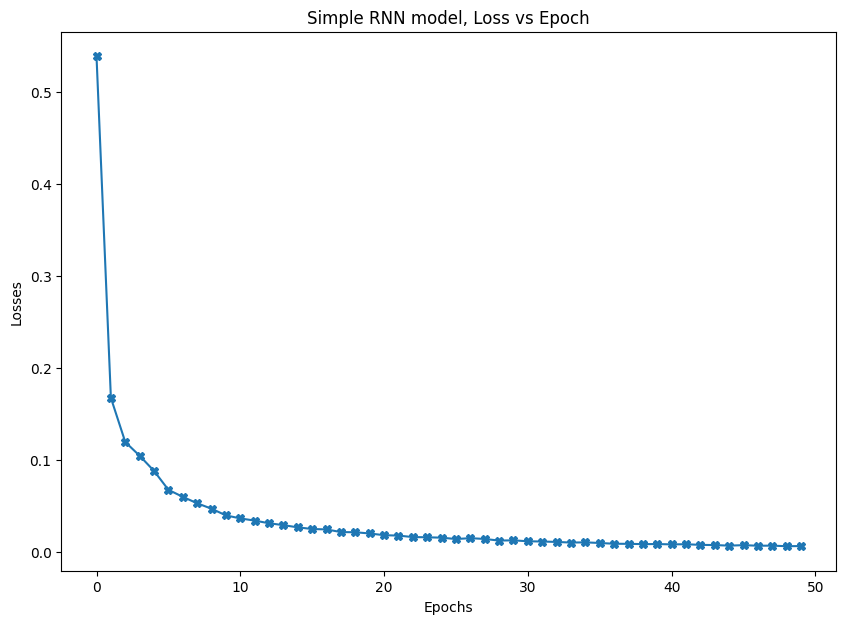

In [ ]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"], marker='X')
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

In [ ]:
y_performance = regressor.predict(X_train)  # predictions


74/74 [==============================] - 1s 5ms/step


In [ ]:
y_pred_performance = scaler.inverse_transform(y_performance) # scaling back from 0-1 to original
y_pred_performance .shape

(2339, 1)

In [ ]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(2339, 1)

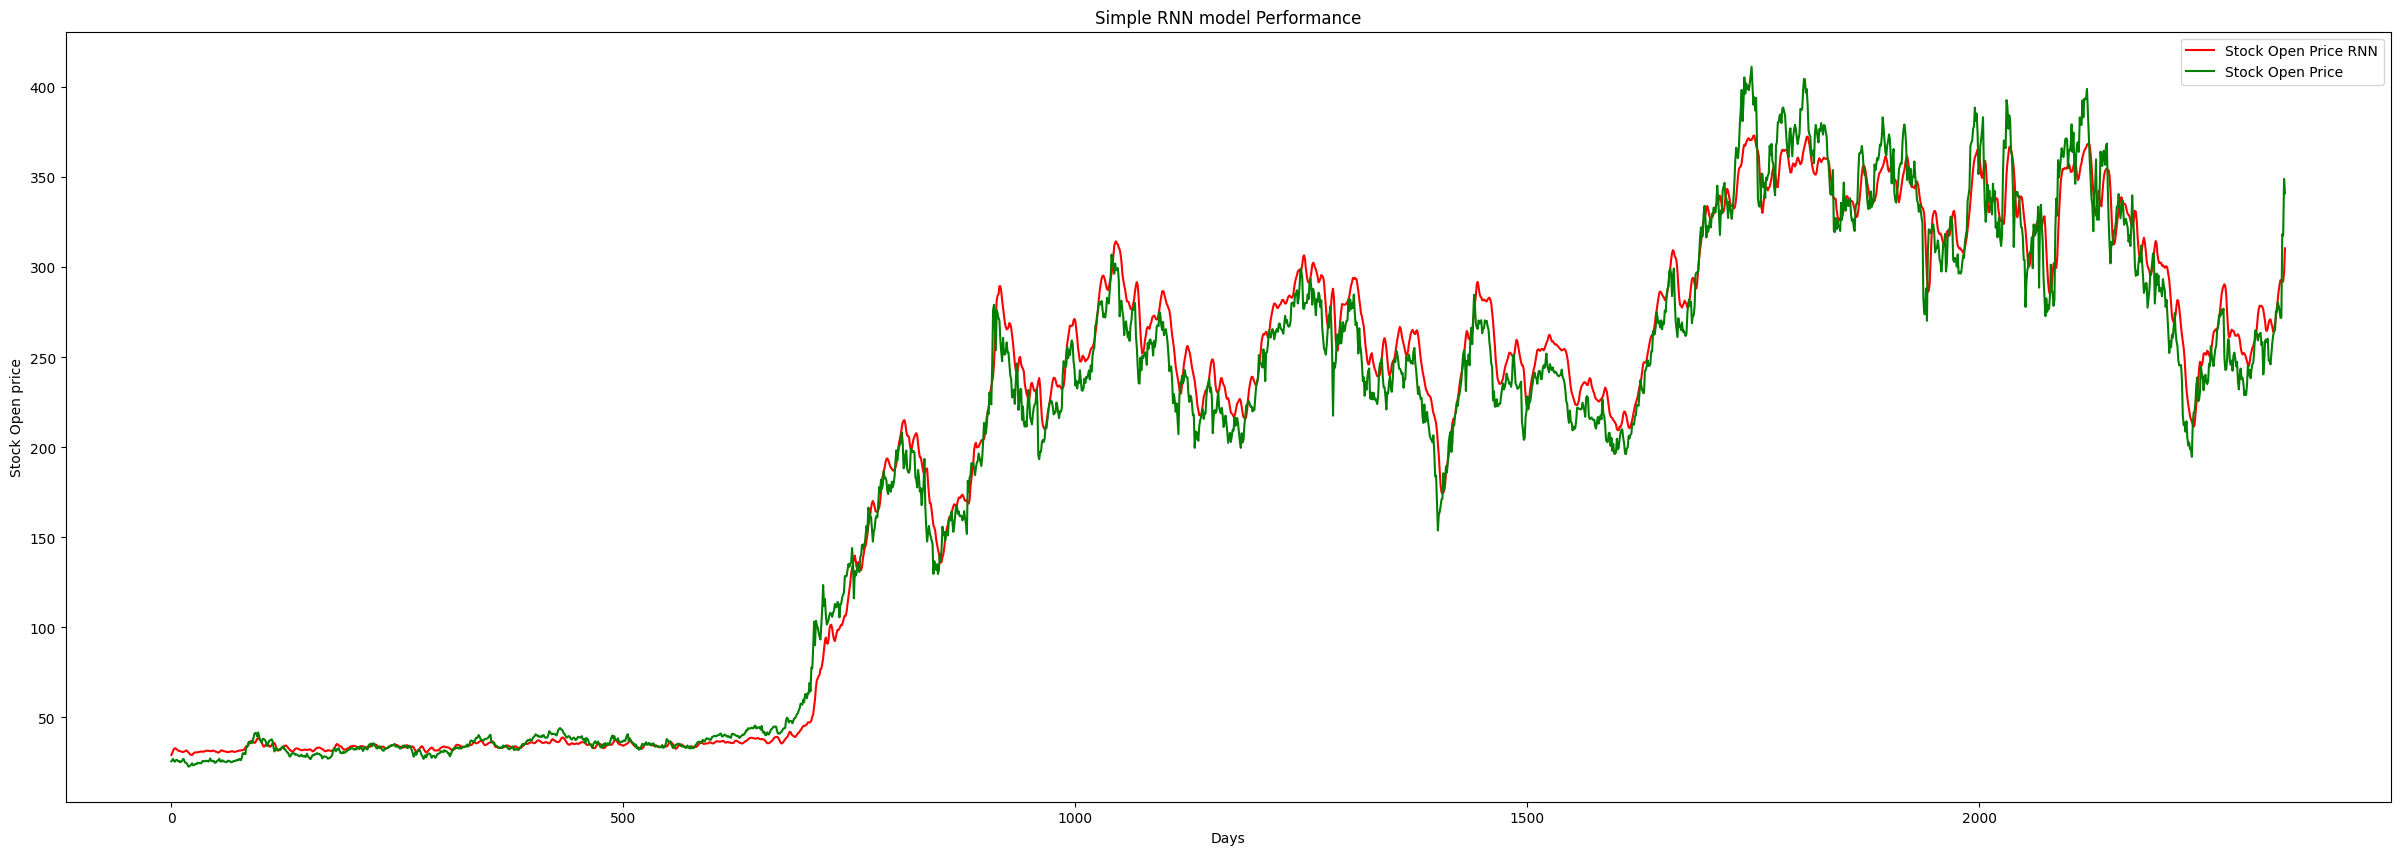

In [ ]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_performance , color = "r", label = "Stock Open Price RNN" )
plt.plot(y_train, color = "g", label = "Stock Open Price")
plt.xlabel("Days")
plt.ylabel("Stock Open price")
plt.title("Simple RNN model Performance")
plt.legend()
plt.show()

In [ ]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test)
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

32/32 [==============================] - 0s 5ms/step
Shape of y_pred_of_test : (997, 1)


In [ ]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(scaler.inverse_transform(y_test), y_pred_of_test)

# Calculate Root Mean Squared Error (RMSE)
rmse= np.sqrt(y_pred_of_test)

# Calculate Mean Absolute Error (MAE)
mae= mean_absolute_error(scaler.inverse_transform(y_test), y_pred_of_test)



print(f'MSE RNN:{np.round(np.mean(mse),3)}')
print(f'RMSE RNN:{np.round(np.mean(rmse),3)}')
print(f'MAE RNN: {np.round(np.mean(mae),3)}')


MSE RNN:325.094
RMSE RNN:13.843999862670898
MAE RNN: 14.459


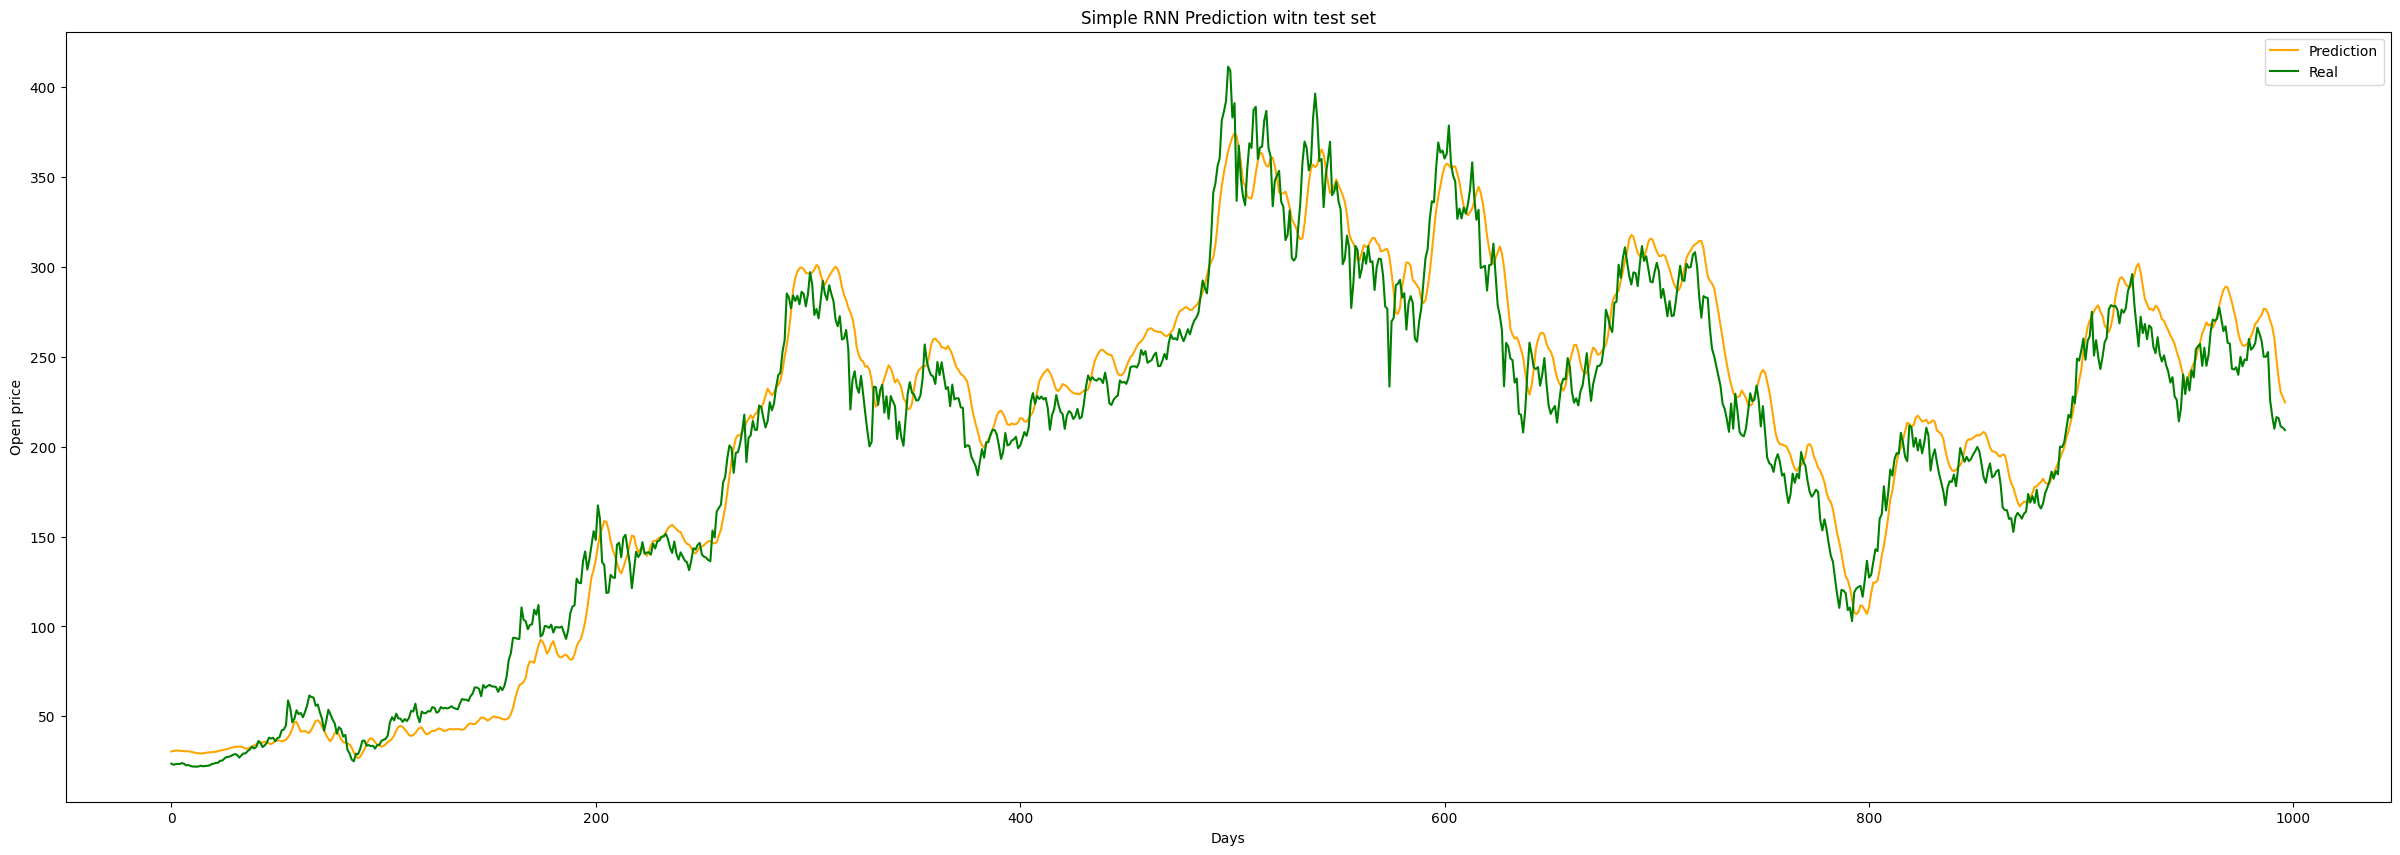

In [ ]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "Prediction", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "Real", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN Prediction witn test set")
plt.legend()
plt.show()

# LSTM

In [ ]:
y_train = scaler.fit_transform(y_train)

In [ ]:
def model2(epochs, batch_size, optimizer):

  from keras.layers import LSTM
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import SimpleRNN
  from keras.layers import Dropout
  model_lstm = Sequential()
  model_lstm.add(
      LSTM(50,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
  model_lstm.add(
    LSTM(50, return_sequences= False))
  model_lstm.add(Dense(64))
  model_lstm.add(Dense(1))
  model_lstm.compile(loss = "mean_squared_error", optimizer = optimizer, metrics = ["mean_squared_error"])

  model_lstm.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

  return f'model_{epochs}_{batch_size}_{optimizer}:{round(np.mean(model_lstm.evaluate(X_train, y_train)),3)}'

In [ ]:
for optimizer in ["adam", "rmsprop", "sgd"]:
  for epochs in [20,50,100]:
    for batch_size in [32,64,128]:
      print(model2(epochs, batch_size, optimizer))

Epoch 1/20
74/74 [==============================] - 4s 5ms/step - loss: 0.0238 - mean_squared_error: 0.0238
Epoch 2/20
74/74 [==============================] - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3/20
74/74 [==============================] - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 4/20
74/74 [==============================] - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 5/20
74/74 [==============================] - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 6/20
74/74 [==============================] - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 7/20
74/74 [==============================] - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 8/20
74/74 [==============================] - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 9/20
74/74 [==============================] - 0s 5ms/step - loss: 9.5313e-04 - mean_squared_error: 9.5313e-04
Epoch 10/20
74/74 [=

In [ ]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(50,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(50, return_sequences= False))
model_lstm.add(Dense(64))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["mean_squared_error"])
history2 = model_lstm.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
74/74 [==============================] - 3s 5ms/step - loss: 0.0182 - mean_squared_error: 0.0182
Epoch 2/50
74/74 [==============================] - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3/50
74/74 [==============================] - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 4/50
74/74 [==============================] - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 5/50
74/74 [==============================] - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 6/50
74/74 [==============================] - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 7/50
74/74 [==============================] - 0s 5ms/step - loss: 0.0010 - mean_squared_error: 0.0010    
Epoch 8/50
74/74 [==============================] - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 9/50
74/74 [==============================] - 0s 5ms/step - loss: 9.6255e-04 - mean_squared_error: 9.6255e-04
Epoch 10/50
74/7

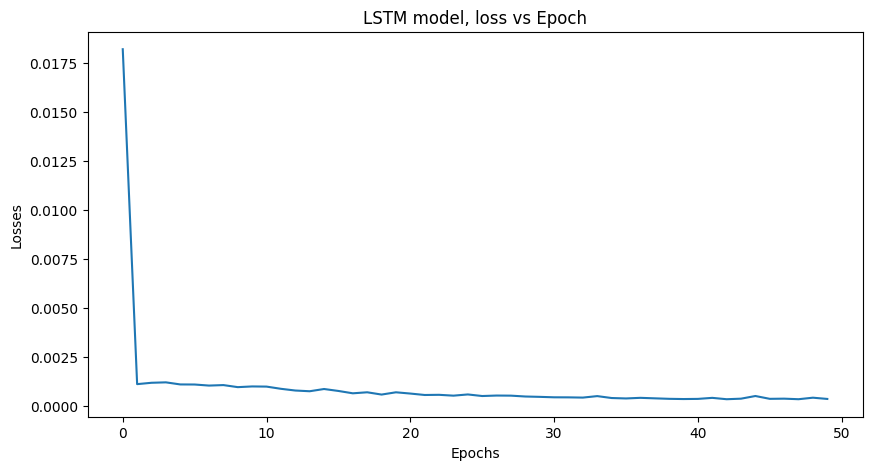

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, loss vs Epoch")
plt.show()

In [ ]:
# Display best accuracy on validation set
max_val_acc = np.min(history2.history['mean_squared_error'])
print(f'Best MSE LSTM: {max_val_acc:.3f}')   # NB: .3f displays 3 decimal places

# Evaluate
Evaluate_baseline = model_lstm.evaluate(X_train, y_train)
print(f'MSE LSTM: {Evaluate_baseline[1]:.3f}')

Best MSE LSTM: 0.000
74/74 [==============================] - 1s 3ms/step - loss: 3.5904e-04 - mean_squared_error: 3.5904e-04
MSE LSTM: 0.000


74/74 [==============================] - 1s 2ms/step


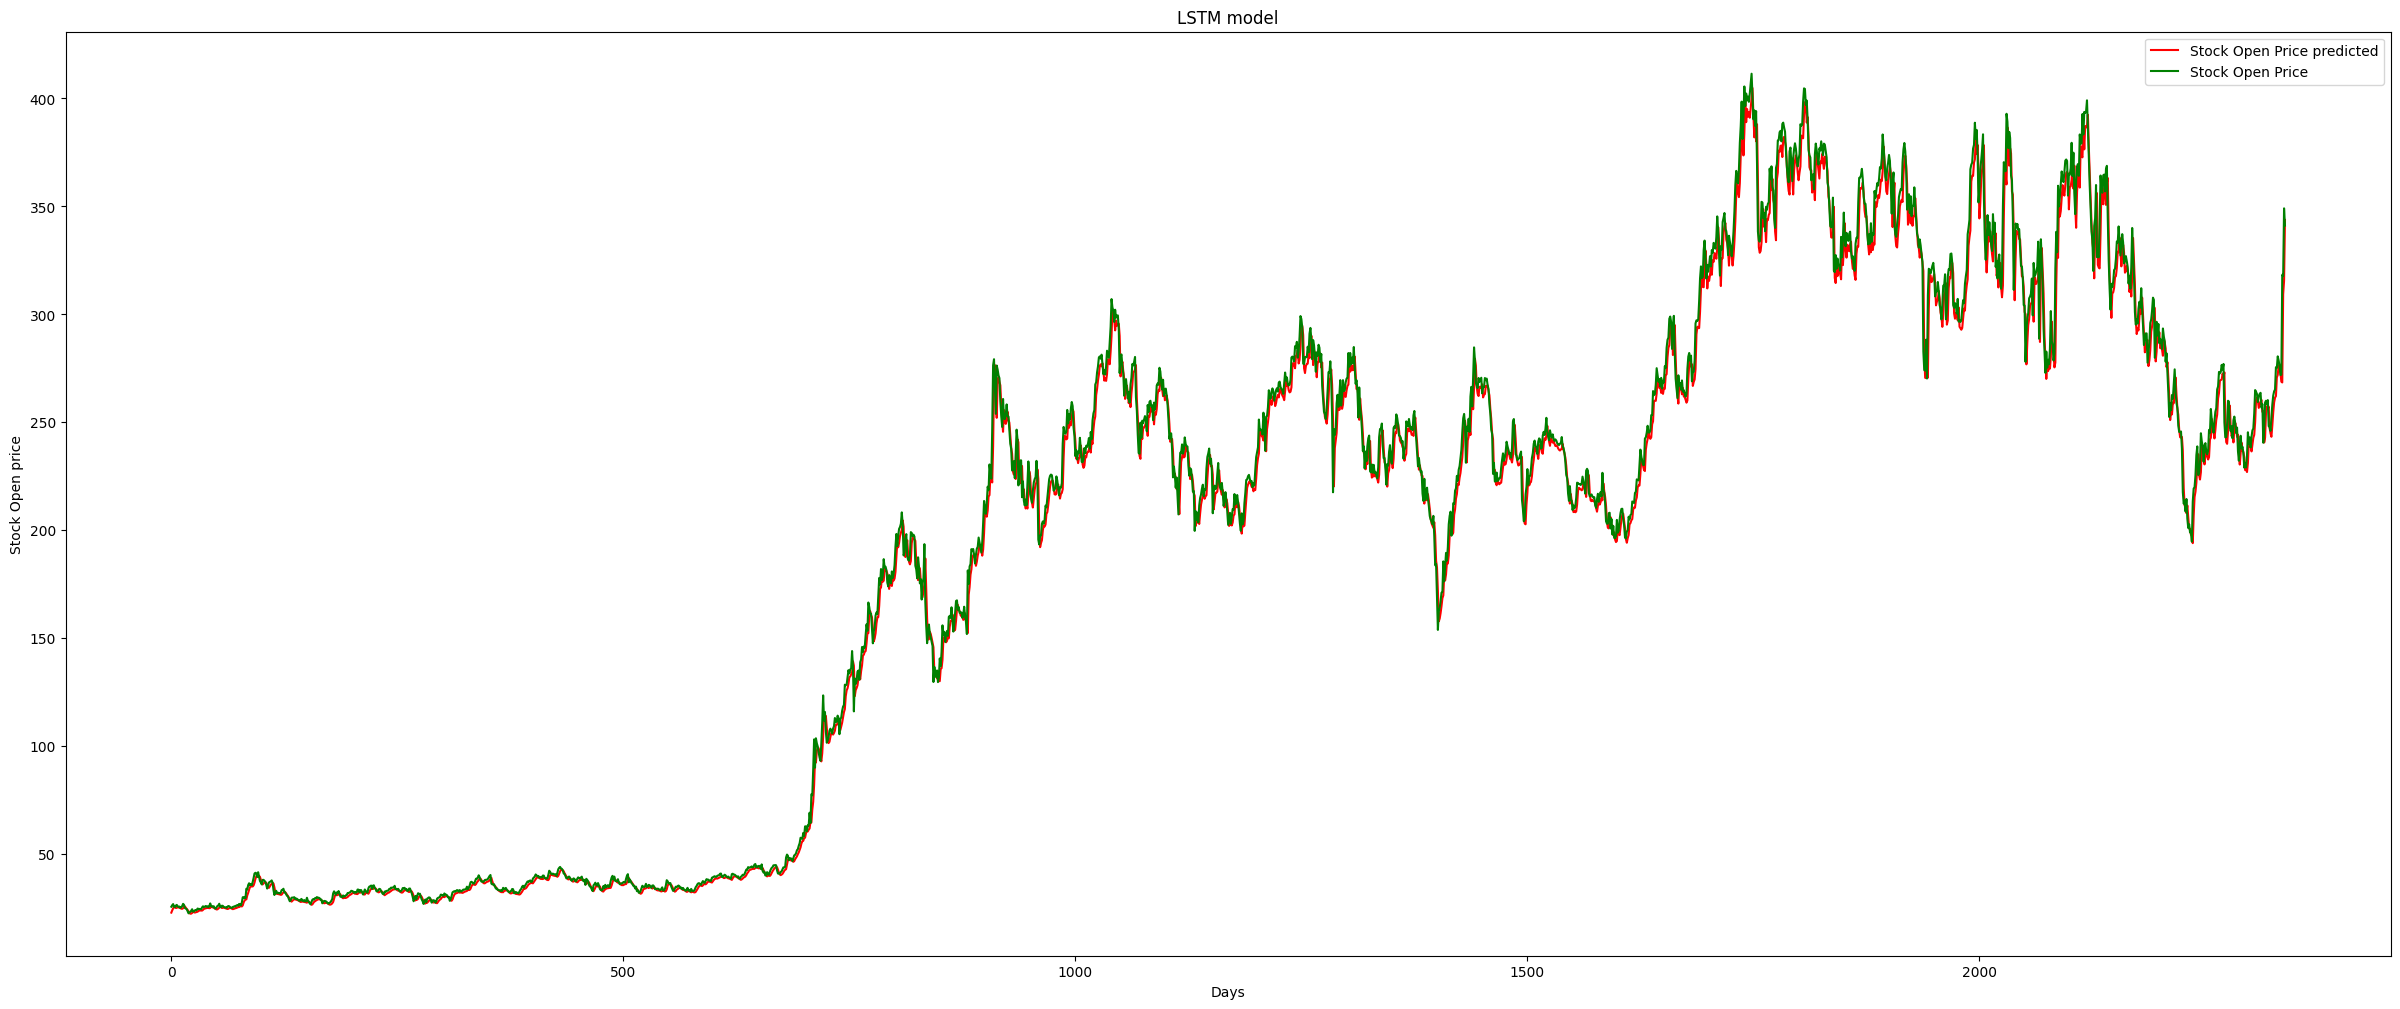

In [ ]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_train)), label = "Stock Open Price predicted", c = "red" )
plt.plot(scaler.inverse_transform(y_train), label = "Stock Open Price", color = "green")
plt.xlabel("Days")
plt.ylabel("Stock Open price")
plt.title("LSTM model")
plt.legend()
plt.show()

In [ ]:
# predictions with X_test data
y_pred_lstm_test = model_lstm.predict(X_test)
# scaling back from 0-1 to original
y_pred_lstm_test = scaler.inverse_transform(y_pred_lstm_test)
print("Shape of y_pred_of_test :",y_pred_lstm_test.shape)

32/32 [==============================] - 0s 3ms/step
Shape of y_pred_of_test : (997, 1)


In [ ]:
# Calculate Mean Squared Error (MSE)
mse_lsmt = mean_squared_error(scaler.inverse_transform(y_test), y_pred_lstm_test)

# Calculate Root Mean Squared Error (RMSE)
rmse_lsmt= np.sqrt(y_pred_lstm_test)

# Calculate Mean Absolute Error (MAE)
mae_lsmt= mean_absolute_error(scaler.inverse_transform(y_test), y_pred_lstm_test)

print(f'MSE Ridge:{np.round(np.mean(mse_lsmt),3)}')
print(f'RMSE Ridge:{np.round(np.mean(rmse_lsmt),3)}')
print(f'MAE Ridge: {np.round(np.mean(mae_lsmt),3)}')



MSE Ridge:95.07
RMSE Ridge:13.597000122070312
MAE Ridge: 7.36


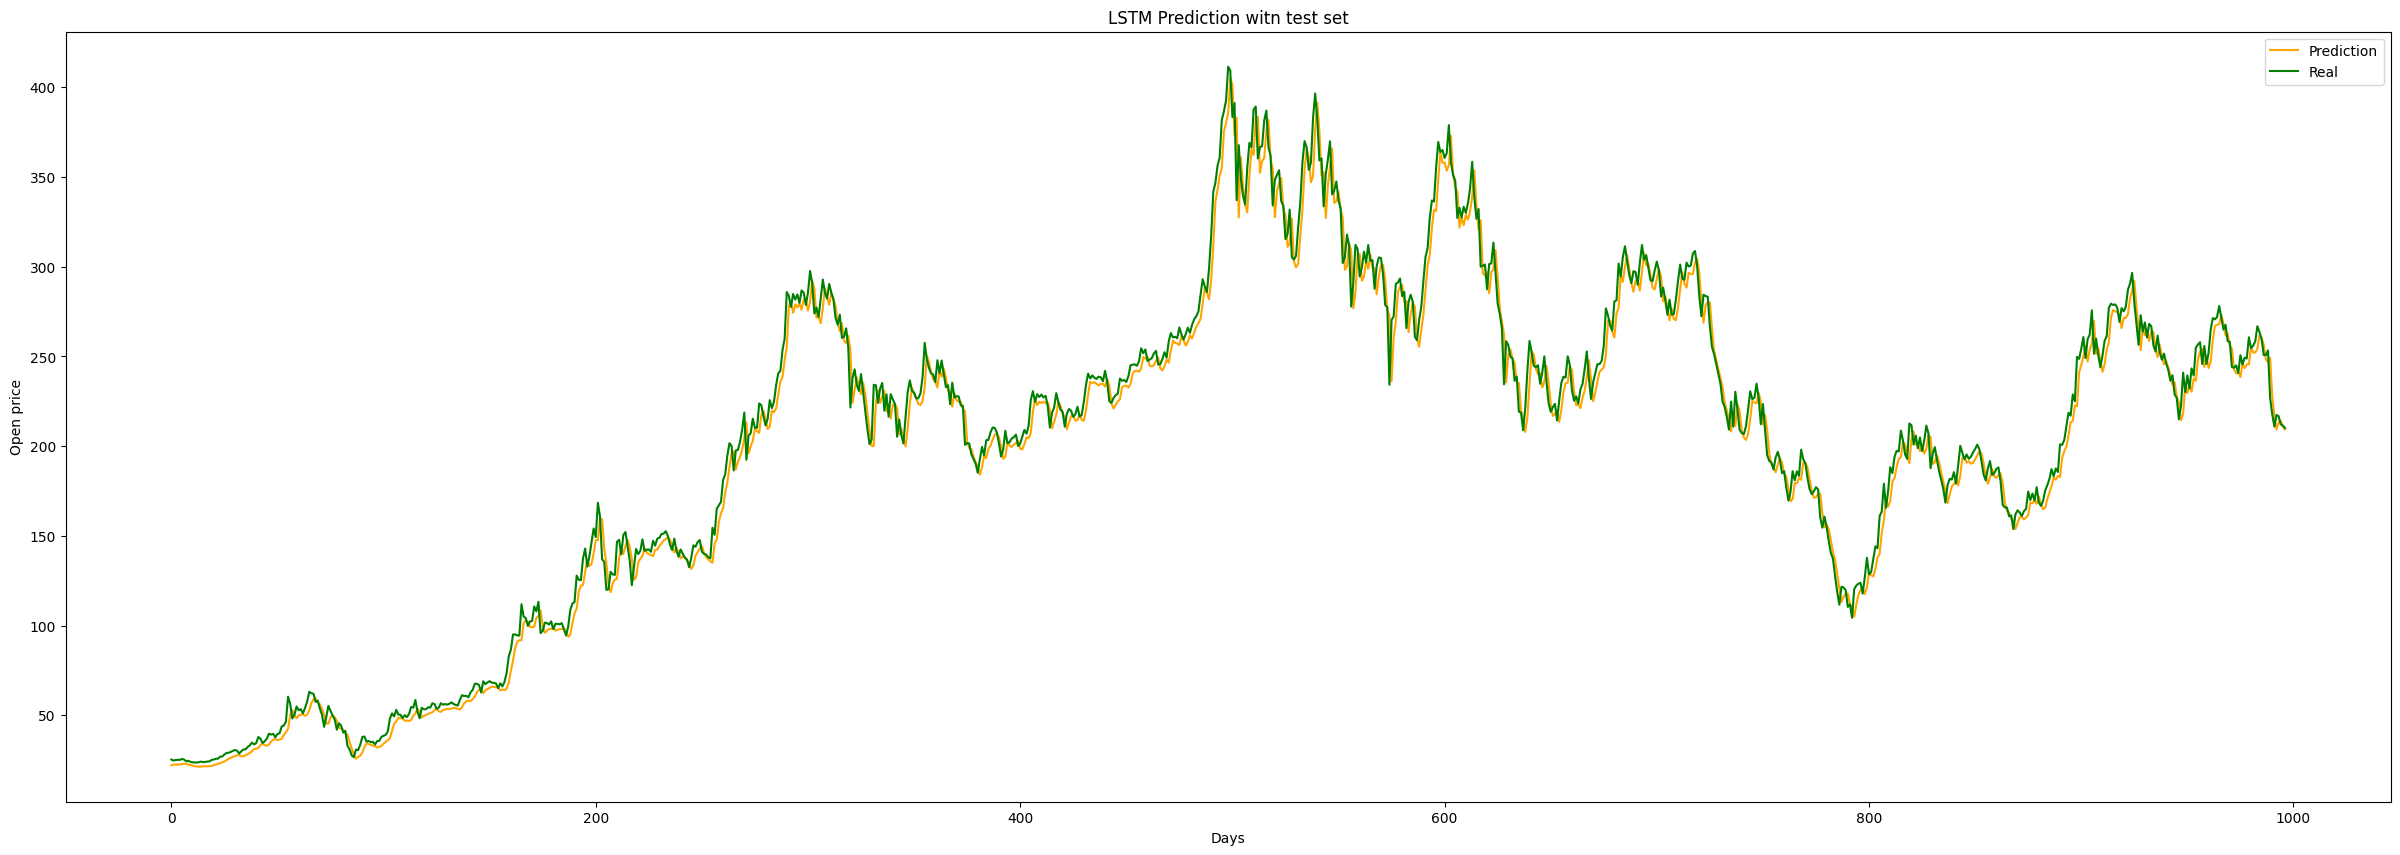

In [ ]:
# visualisation
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_lstm_test, label = "Prediction", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "Real", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM Prediction witn test set")
plt.legend()
plt.show()